# Market Segmentation

In this notebook, we're looking at a dataset containing the usage behavior of about 9000 active credit cardholders during the last 6 months. Our goal is to use Unsupervised Learning in order to create clusters of credit cardholders with similar behaviors. 

In [1]:
import csv
import os
import time
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
%matplotlib inline

### Loading the data

In [2]:
df = pd.read_csv("Customer_Data.csv")

In [3]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
print(f"{np.shape(df)[0]} rows")
print("\nColumns:")
for i in range(len(list(df.columns))): print("||",list(df.columns)[i])

8950 rows

Columns:
|| CUST_ID
|| BALANCE
|| BALANCE_FREQUENCY
|| PURCHASES
|| ONEOFF_PURCHASES
|| INSTALLMENTS_PURCHASES
|| CASH_ADVANCE
|| PURCHASES_FREQUENCY
|| ONEOFF_PURCHASES_FREQUENCY
|| PURCHASES_INSTALLMENTS_FREQUENCY
|| CASH_ADVANCE_FREQUENCY
|| CASH_ADVANCE_TRX
|| PURCHASES_TRX
|| CREDIT_LIMIT
|| PAYMENTS
|| MINIMUM_PAYMENTS
|| PRC_FULL_PAYMENT
|| TENURE


### Cleaning the dataset

We search for columns with NaN values and replace these NaN values by the median of their associated column

In [8]:
col_nan = list(df.columns[df.isna().any()])
print(f"Columns with NaN values: {col_nan}")
for c in col_nan:
    median_value = df[c].median()
    df[c].fillna(median_value, inplace=True)

Columns with NaN values: []


### Numerical statistics

In [12]:
numerical_cols = list(df.select_dtypes(include=['number']).columns)
non_numerical_cols = list(df.select_dtypes(exclude=['number']).columns)
print(f"Non numerical columns: {non_numerical_cols}")

Non numerical columns: ['CUST_ID']


In [31]:
d = df.drop(columns=['CUST_ID'])

infos_data = {
    'Column': [],
    'Type': [],
    'Min' : [],
    'Max' : [],
    'Mean' : [],
    'Std' : [],
    'Median' : []
}

for c in d.columns:
    infos_data['Column'].append(c)
    infos_data['Type'].append(d[c].dtype)
    infos_data['Min'].append(min(d[c]))
    infos_data['Max'].append(max(d[c]))
    infos_data['Mean'].append(statistics.mean(list(d[c])))
    infos_data['Std'].append(statistics.pstdev(list(d[c])))
    infos_data['Median'].append(statistics.median(list(d[c])))

infos_df = pd.DataFrame(infos_data)

In [32]:
pd.DataFrame.from_dict(infos_data)

,Column,Type,Min,Max,Mean,Std,Median
0,BALANCE,float64,0.000000,19043.13856,1564.474828,2081.415590,873.385231
1,BALANCE_FREQUENCY,float64,0.000000,1.00000,0.877271,0.236891,1.000000
2,PURCHASES,float64,0.000000,49039.57000,1003.204834,2136.515413,361.280000
3,ONEOFF_PURCHASES,float64,0.000000,40761.25000,592.437371,1659.795184,38.000000
4,INSTALLMENTS_PURCHASES,float64,0.000000,22500.00000,411.067645,904.287592,89.000000
5,CASH_ADVANCE,float64,0.000000,47137.21176,978.871112,2097.046713,0.000000
6,PURCHASES_FREQUENCY,float64,0.000000,1.00000,0.490351,0.401348,0.500000
7,ONEOFF_PURCHASES_FREQUENCY,float64,0.000000,1.00000,0.202458,0.298319,0.083333
8,PURCHASES_INSTALLMENTS_FREQUENCY,float64,0.000000,1.00000,0.364437,0.397426,0.166667
9,CASH_ADVANCE_FREQUENCY,float64,0.000000,1.50000,0.135144,0.200110,0.000000


### Data Distribution

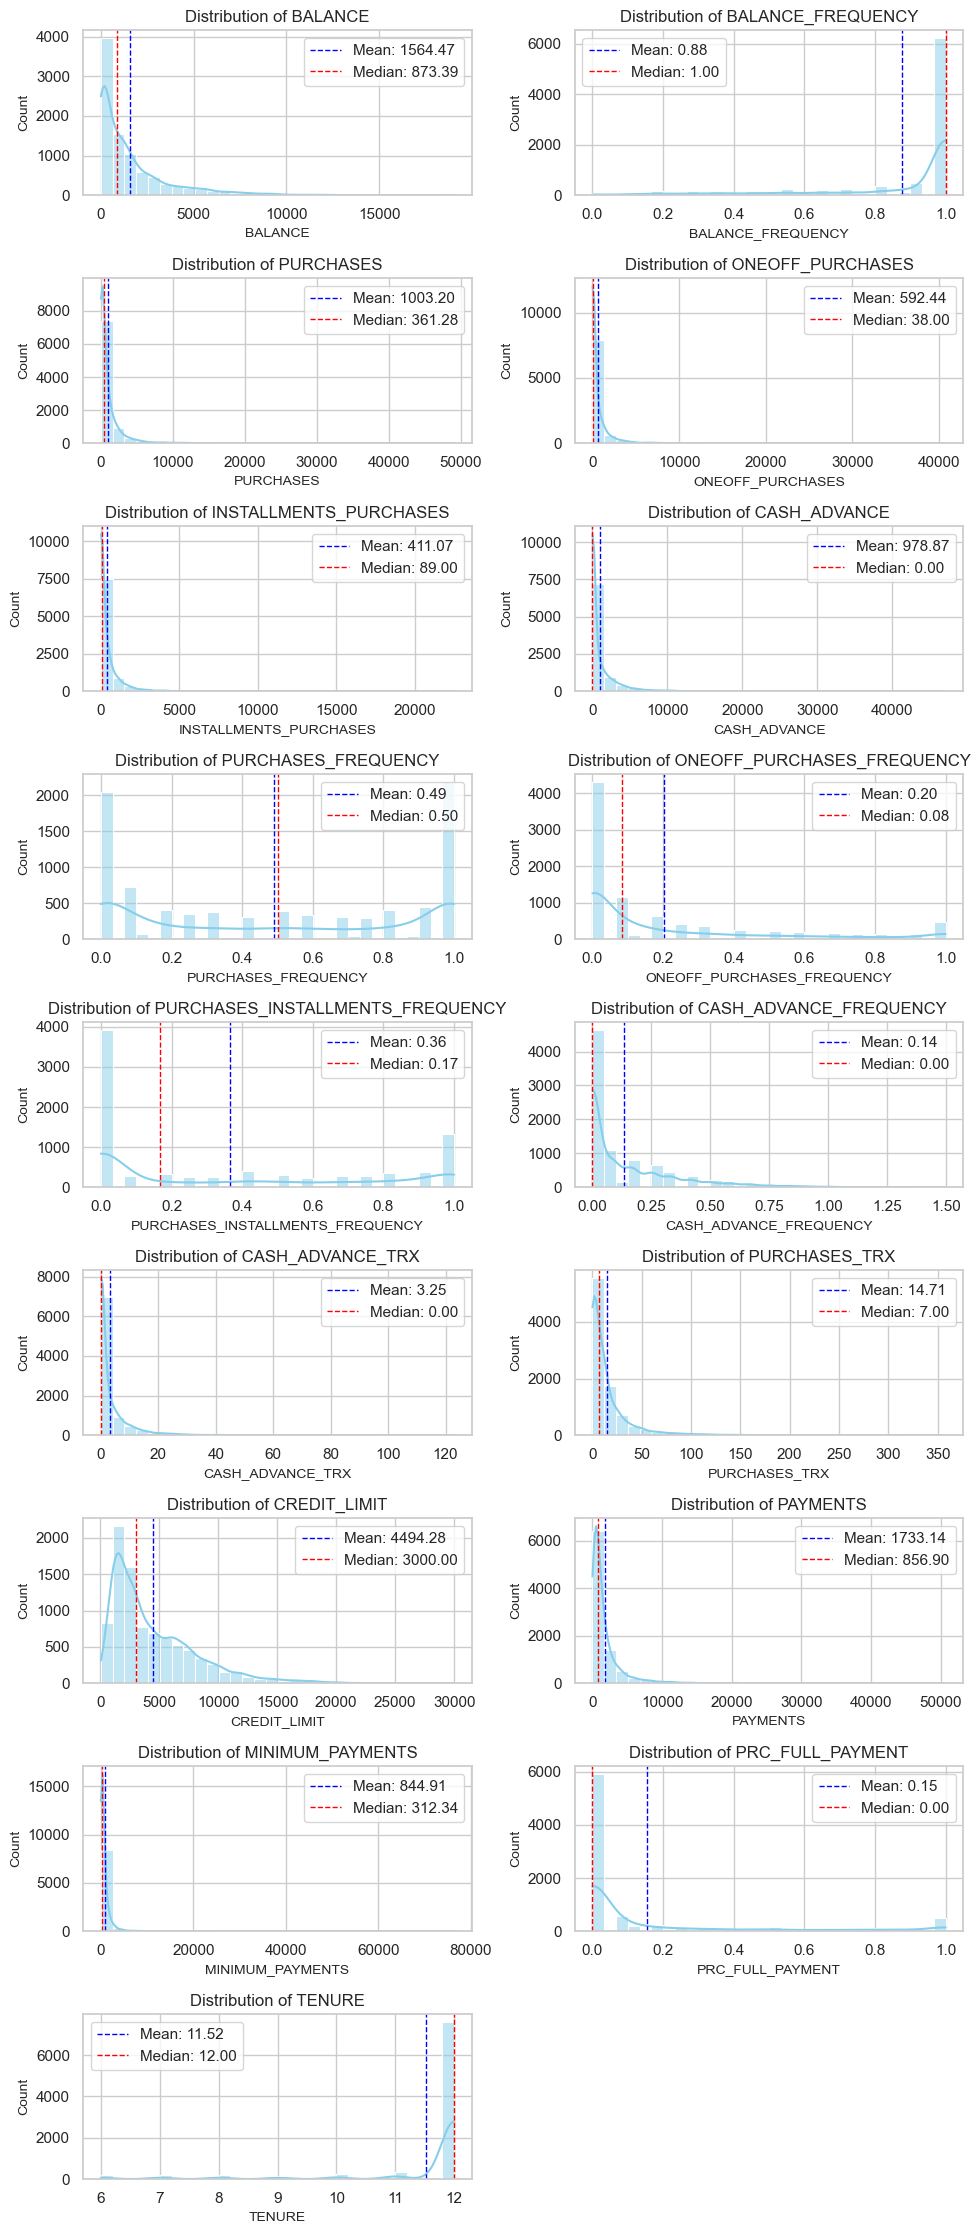

In [46]:
sns.set(style='whitegrid')

n_cols = 2
n_rows = (len(d.columns) + 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 2.5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(d.columns):
    ax = axes[idx]
    sns.histplot(d[col], bins=30, kde=True, color="skyblue", ax=ax)
    mean_val = d[col].mean()
    median_val = d[col].median()
    ax.axvline(mean_val, color="blue", linestyle="dashed", linewidth=1, label=f"Mean: {mean_val:.2f}")
    ax.axvline(median_val, color="red", linestyle="dashed", linewidth=1, label=f"Median: {median_val:.2f}")
    ax.legend()
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Count", fontsize=10)

plt.tight_layout()
for idx in range(len(d.columns), n_cols * n_rows):
    fig.delaxes(axes[idx])

plt.show()

### Features Correlation

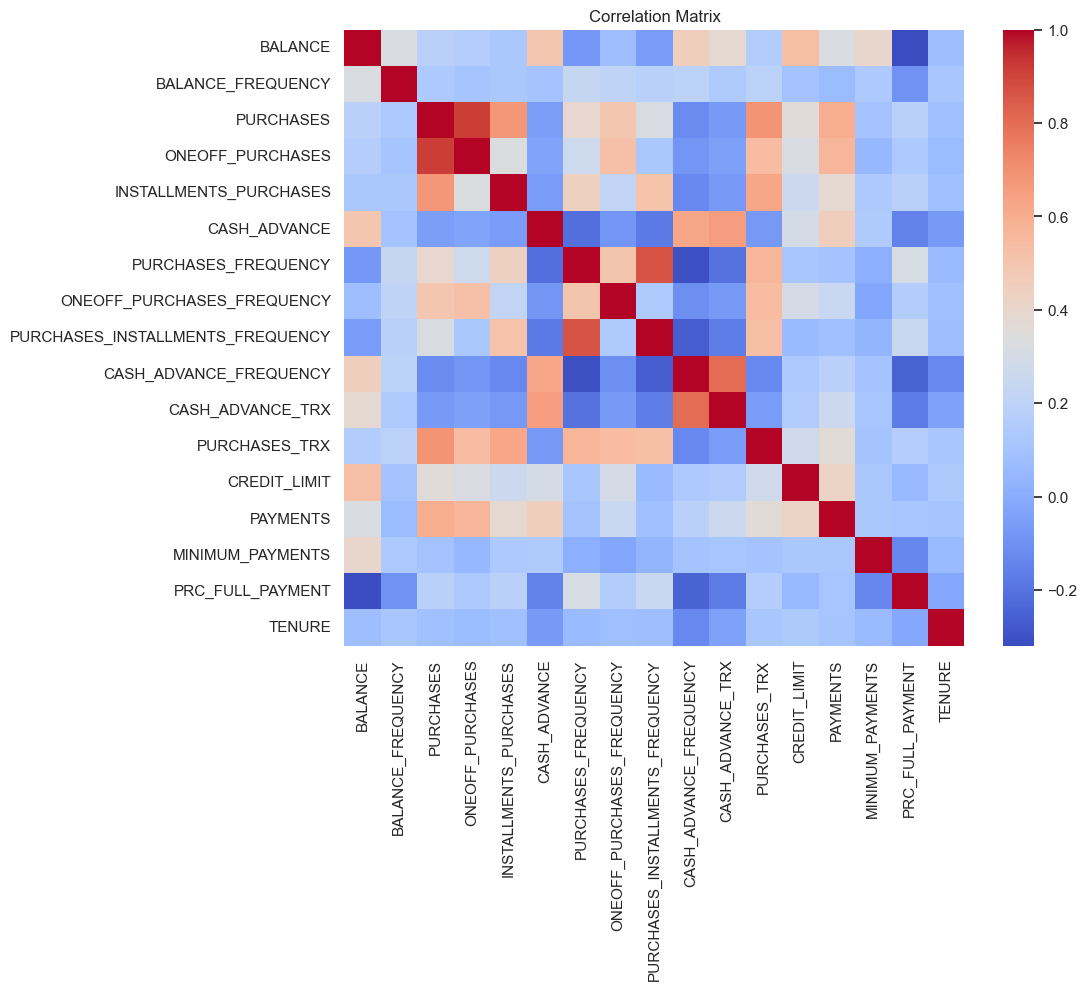

In [52]:
corr = d.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()